In [209]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Automatic differentiation for genetic circuit optimisation: a JAX showcase

In this notebook, we will set up a simple genetic circuit and try to achieve robust adaptation.

## Imports 

In [210]:
import os
import sys
import numpy as np
import jax.numpy as jnp
import jax
import diffrax as dfx
import optax

from typing import NamedTuple, Tuple
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from functools import partial

from synbio_morpher.utils.results.analytics.timeseries import compute_precision, compute_sensitivity, compute_peaks

jax.config.update('jax_platform_name', 'gpu')


# if __package__ is None:

module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

__package__ = os.path.basename(module_path)

rng = jax.random.PRNGKey(0)

jax.devices()


np.random.seed(0)



## Set up circuits

In [211]:
n_species = 4
n_circuits = 100
species_idx_in = 0

jr = jax.random.PRNGKey(42)

circuit_params = jax.random.uniform(jr, shape=(n_circuits, n_species, n_species)) - 0.5

## Set up gene circuits

In [212]:
def make_params(mag, sign):
    return mag * sign

def init_circuit():
    """
    y: abundance of each species
    n: size of circuit
    """
    tf_names = ['P0', 'P1', 'P2']
    
    n = len(tf_names)
    y = np.zeros(n)
    
    # Activation / repression strength between tfs in log scale. Direction is from row index to column index.
    # Repression is negative in the direction matrix
    magnitudes = np.zeros((n, n))
    directions = np.zeros((n, n))  # [-1, 1]
    
    return tf_names, y, magnitudes, directions, n


# def ensure_adaptable(directions, relevant_species_idxs):
#     """ Ensure that conditions for robust adaptation are met, as described in 
#     Bhattacharya et al. 2022, "Discovering adaptation-capable biological network structures using control-theoretic approaches"
#     https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1009769#sec005  
#     """
#     nodes_that_matter_mask = np.ones_like(directions)
#     nodes_that_matter_mask[relevant_species_idxs] = 0.0
#     np.where(directions * nodes_that_matter_mask == -1)
    
    
def adaptable_motifs():
    """ Fromm Bhattacharya et al. 2022, "Discovering adaptation-capable biological network structures using control-theoretic approaches"
    https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1009769#sec005 """
    
    motif1 = np.array(
        [[0, -1, 1,],
         [0, 0, 1],
         [0, 0, 0]]
    )
    
    motif2 = np.array(
        [[0, -1, 1,],
         [1, 0, 0],
         [0, 0, 0]]
    )
    
    return [motif1, motif2]
    

def make_rand_circuits():
    tf_names, y, magnitudes, directions, n = init_circuit()
    n_circ = 100
    mag_hi = 1e1
    y0_max = 10
    species_idx_in = 0
    species_idx_out = n-1
    
    # y0 = np.random.randint(1, y0_max, y.size * n_circ).reshape((n_circ, *y.shape))
    # y0 = np.random.rand(n_circ, *y.shape)
    # y0[:, species_idx_in] = 0
    y0 = np.zeros((n_circ, *y.shape))
    
    # magnitudes = (np.random.rand(n_circ, *magnitudes.shape) - 0.5) * mag_hi
    # magnitudes = np.power(10, magnitudes)
    # magnitudes = np.random.rand(*magnitudes.shape) + 1
    # magnitudes = magnitudes / magnitudes.max()
    
    # directions = np.where(np.random.rand(n_circ, *directions.shape) > 0.5, 1.0, -1.0)
    # kd = np.random.randint(1, 50, size=y0.size).reshape(y0.shape) / 50
    
    # Attempt 2
    magnitudes = np.abs(np.random.normal(0,0.1,(n_circ, n, n)))
    directions = np.ones((n_circ, n, n)) * adaptable_motifs()[0]
    kt = np.abs(np.random.normal(0,0.1,y0.shape))   # Transcription baseline rate
    kd = np.abs(np.random.normal(0,0.1,y0.shape))   # Degradation baseline rate
    kt = 0.01 * np.ones_like(kt)
    kd = 0.07 * np.ones_like(kd)
    
    # jax.vmap(partial(ensure_adaptable, relevant_species_idxs=np.array([species_idx_in, species_idx_out])))(directions)
    
    return y0, magnitudes, directions, kt, kd, tf_names, species_idx_in, species_idx_out, n_circ


y0, magnitudes, directions, kt, kd, tf_names, species_idx_in, species_idx_out, n_circ = make_rand_circuits()
params = make_params(magnitudes, directions)



In [213]:
params[0], kt[0], kd[0], y0[0]

(array([[ 0.        , -0.04001572,  0.0978738 ],
        [ 0.        ,  0.        ,  0.09772779],
        [ 0.        ,  0.        ,  0.        ]]),
 array([0.01, 0.01, 0.01]),
 array([0.07, 0.07, 0.07]),
 array([0., 0., 0.]))

## Set up equations

In [214]:
def one_step_de_sim_expanded(y, inputs, outputs, kf, kr):
    y_factors_in = jnp.prod(
        jnp.power(y, (inputs)), axis=1)
    y_factors_out = jnp.prod(
        jnp.power(y, (outputs)), axis=1)
    df = y_factors_in * kf
    dr = y_factors_out * kr
    return (df - dr) @ (outputs - inputs)


In [215]:
class SignalParams(NamedTuple):
    t_thresh: jnp.float64
    sig_hi: jnp.float64
    sig_lo: jnp.float64
    signal_mask: jax.Array


def signal(t, signal_params: SignalParams, as_deriv = True):

    t_bound = 2.0

    if as_deriv:
        return jnp.where((t > signal_params.t_thresh - t_bound) & (t < signal_params.t_thresh + t_bound), 
                     signal_params.sig_hi, signal_params.sig_lo) * signal_params.signal_mask
    return jnp.where(t > signal_params.t_thresh, signal_params.sig_hi, signal_params.sig_lo) * signal_params.signal_mask


def make_ode(params, kt, kd, sig_params):
    def ode(t, y, args) -> jnp.ndarray:
        """
        Args:
            t (np.ndarray): time (1D)
            y (np.ndarray): amount of each species (axes [t, n_species])
            params (np.ndarray): parameters governing ode
            sig_params (dict): kwargs to signal function
        Returns:
            jnp.ndarray: derivative term of y
        """

        x_sig = signal(t, sig_params)
        y_sig = y + x_sig

        # phi = 1/(jnp.exp(-t)+1)
        phi = 1
        # x_interactions = jnp.dot(params, y)
        x_interactions = (params * y_sig[None, :].T).sum(axis=0) 

        # dx = phi * x_interactions - kd * y + x_sig
        dx = phi * jnp.where(x_interactions > 0, x_interactions, x_interactions * y) + kt - kd * y + x_sig
        # dx = phi * x_interactions + kt - kd * y

        return dx
    return ode

### Loss

In [216]:
def calc_robustness(s, p, s_skew: int = 5):
    # s, p = np.log10(s), np.log10(p)
    high_num = 1e10
    p_clamped = jnp.where(p > high_num, high_num, p)
    s_lin = 1/jnp.where(p_clamped == 0, 1.0, p)
    return s * p_clamped * jnp.power(s - s_lin, s_skew)


def compute_robustness(y, signal_idx, w_sensitivity=1.0):
    y0, y1 = y[0, :], y[-1, :]
    y_min = jnp.where(y.min(axis=0) == 0, 1.0, y.min(axis=0))
    y0 = jnp.where(y[0, :] == 0, jnp.ones_like(y[0, :]), y[0, :])
    # y1 = jnp.where(y[-1, :] == 0, 1, y[-1, :])
    sig_0, sig_1 = y0[signal_idx], y1[signal_idx]

    sig_0_corrected = jnp.where(sig_0 == 0, 1, sig_0)

    s = compute_sensitivity(signal_idx, starting_states=y0, peaks=compute_peaks(
        y0, y1, y.max(axis=0), y_min))
    p = compute_precision(starting_states=y0,
                          steady_states=y1, signal_0=sig_0_corrected, signal_1=sig_1)
    s_crct = jnp.where((jnp.abs(1.0 - s) * 1e-2) < 1e-7, 0.0, s)
    p_crct = jnp.where((jnp.abs(1.0 - p) * 1e-2) < 1e-4, 0.0, p)

    # r = calc_robustness(s_crct, p_crct, s_skew=7)
    denom = (jnp.log10(p_crct * 1e-2))
    numer = jnp.log10(s_crct * w_sensitivity)
    r = jnp.where(numer == -jnp.inf, 0, numer) / denom
    r = jnp.power(10, r)
    # r = jnp.abs(jnp.where(numer == -jnp.inf, 0, numer)) / jnp.abs(denom)
    return r  # jnp.where((r == np.nan) | (jnp.abs(r) == jnp.inf), 0.0, r)


def reg_loss(params, setpoint_mean=0.1):
    # return setpoint_mean - jnp.abs(params).mean()
    return - jnp.log10(params.mean())


def cost_f(y, params, signal_idx, output_idx):

    robustness = compute_robustness(y, signal_idx, w_sensitivity=10)
    loss = - robustness[..., output_idx]
    
    # loss += reg_loss(params)
    # return - jnp.log(robustness[..., output_idx])
    return loss


def sim_jax(f_dx, y0, t0, t1, dt0):

    solver = dfx.Dopri5()
    stepsize_controller = dfx.PIDController(rtol=1e-7, atol=1e-9)
    saveat = dfx.SaveAt(ts=jnp.linspace(t0, t1, 100))

    term = dfx.ODETerm(f_dx)
    sol = dfx.diffeqsolve(
        term, solver, t0, t1, dt0, y0, saveat=saveat,
        stepsize_controller=stepsize_controller, max_steps=16**6
    )
    ys, ts = sol.ys, sol.ts
    return ys, ts


def sim_nojax(f_dx, y0, t0, t1, dt0):

    ts = np.arange(t0, t1, dt0)
    ys = np.zeros((len(ts), *y0.shape))
    ys[0] = y0
    for i, ti in enumerate(ts):
        if i == 0:
            continue
        y0 += f_dx(ti, y0, None) * dt0
        ys[i] = y0
    return ys, ts


def train_loop(y0, params, kt, kd, use_jax=True):

    t0, t1, dt0 = 0.0, 100.0, 0.001

    signal_mask = np.zeros(y0.shape)
    signal_mask[species_idx_in] = 1.0
    sig_params = SignalParams(t_thresh=0, sig_lo=0.0,
                              sig_hi=100.0, signal_mask=signal_mask)

    f_dx = make_ode(params, kt, kd, sig_params)

    if use_jax:
        ys, ts = sim_jax(f_dx, y0, t0, t1, dt0)
    else:
        ys, ts = sim_nojax(f_dx, y0, t0, t1, dt0)

    return ys, ts


# ys, ts = jax.jit(jax.vmap(train_loop))(y0, params, kd)
ys, ts = jax.vmap(partial(train_loop, use_jax=True))(y0, params, kt, kd)
# ys, ts = train_loop(y0[0], params[0], kt[0], kd[0], use_jax=True)

### Visualise

In [217]:

# signal_mask = np.zeros(y0.shape)
# signal_mask[species_idx_in] = 1.0
# sig_params = SignalParams(t_thresh=0, sig_lo=0.0, sig_hi=100.0, signal_mask=signal_mask[0])

# plt.plot(ts[0], ys[0], label=tf_names)
# # plt.plot(ts, ys, label=tf_names)
# # plt.plot(ts, jax.vmap(partial(signal, signal_params=sig_params, as_deriv=False))(ts)[:, 0], label='signal function')
# plt.legend()

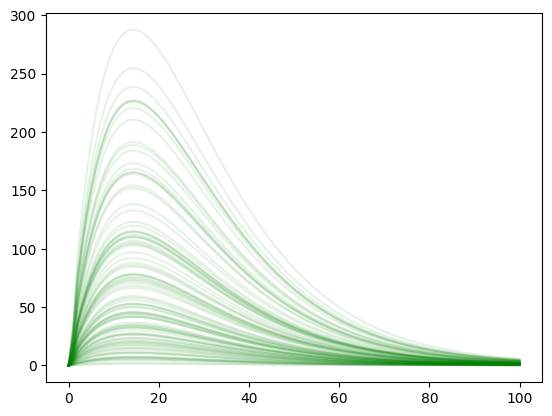

In [218]:
plt.plot(ts[0], ys[:, :, 2].T, color='g', alpha=0.1)
plt.show()

<Axes: >

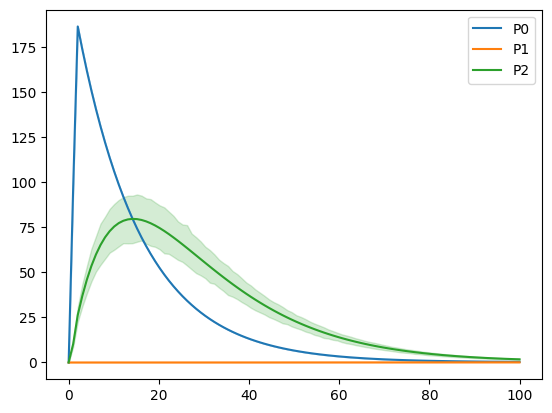

In [219]:
df = pd.DataFrame(data=ys.reshape((np.product(ys.shape[:-1]), ys.shape[-1])), index=ts.reshape(ts.size), columns=tf_names)

sns.lineplot(df, alpha=1, dashes=False)

## Set up optimisation

In [220]:
class TrainingParams(NamedTuple):
    # l2_reg_alpha = 0.1
    learning_rate = 0.001
    warmup_epochs = 5
    epochs = 50


training_params = TrainingParams()
cosine_epochs = max(training_params.epochs - training_params.warmup_epochs, 1)
cosine_fn = optax.cosine_decay_schedule(
    init_value=training_params.learning_rate, decay_steps=1000)  # , alpha=l2_reg_alpha)
schedule_fn = cosine_fn
optimiser = optax.adam(learning_rate=schedule_fn)

In [221]:
class TrainingState(NamedTuple):
    """Container for the training state."""
    params: jax.Array  # Current network parameters.
    opt_state: optax.OptState  # Optimiser state (e.g. gradient moments).
    rng_key: jax.Array  # RNG used for e.g. dropout. Split on each update step.
    step: jax.Array  # Tracks the number of training steps.


@jax.jit
def init_train(rng: jax.Array, initial_params) -> TrainingState:
    """Makes an initial training state (random parameters)."""
    # rng, init_rng = jax.random.split(rng)
    initial_opt_state = optimiser.init(initial_params)
    return TrainingState(
        params=initial_params,
        opt_state=initial_opt_state,
        rng_key=rng,
        step=jnp.array(0),
    )


# @jax.jit
def loss_fn(params, y0, kt, kd, species_idx_in, species_idx_out, directions):

    # kt = kt.mean(axis=-1).squeeze()
    # kd = kd.mean(axis=-1).squeeze()
    ys, ts = jax.vmap(partial(train_loop, use_jax=True))(
        y0, 
        jnp.abs(params) * directions, 
        kt, kd)
    
    loss = jax.vmap(partial(cost_f, signal_idx=species_idx_in, output_idx=species_idx_out))(ys, params).sum()
    
    return loss


def make_scan_f(y0, kt, kd, species_idx_in, species_idx_out, directions):
    def f_scan(inp, cr):

        state = inp
        params, optimiser_state = state.params, state.opt_state
        # circ_params, kt, kd = params
        
        cost, grads = jax.value_and_grad(loss_fn, argnums=0)(params, y0, kt, kd, species_idx_in, species_idx_out, directions)
        updates, new_opt_state = optimiser.update(grads, optimiser_state)
        
        new_params = optax.apply_updates(params, updates[0])
        new_state = TrainingState(
            params=new_params,
            opt_state=new_opt_state,
            rng_key=rng,
            step=state.step + 1,
        )
        
        return new_state, [cost, params, grads]
    return f_scan
    

## Run

In [222]:
# circ_params = params
# ktn = np.repeat(kt[:, :, None], repeats=kt.shape[-1], axis=-1)
# kdn = np.repeat(kd[:, :, None], repeats=kd.shape[-1], axis=-1)
# params = np.concatenate([circ_params, ktn, kdn])
# params = params.reshape((3, n_circ, *circ_params.shape[-2:]))


In [223]:
cs = np.zeros([training_params.epochs, n_circ])
rs = np.zeros([training_params.epochs, *params.shape])

seed = 0
state = init_train(jax.random.PRNGKey(seed), params)

f_scan = jax.jit(make_scan_f(y0, kt, kd, species_idx_in, species_idx_out, directions))
new_state, crs_all = jax.lax.scan(f_scan, init=state, xs=[cs, rs, cs])


In [224]:
np.where(np.isnan(crs_all[2]))

(array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64))

In [225]:
crs_all[0] 

Array([-7.75295410e+01, -8.61089096e+01, -9.38728638e+01, -1.34431564e+02,
       -1.06274406e+02, -1.74956482e+02, -1.16001129e+02, -1.05535042e+02,
       -1.01186150e+02, -1.27481972e+02, -1.06545868e+02, -1.01789886e+02,
       -1.04939865e+02, -9.93147659e+01, -1.48405945e+02, -1.00894653e+02,
       -1.09300919e+02, -1.38446747e+02, -1.23242126e+02, -1.15637535e+02,
       -1.37582672e+02, -1.11074516e+02, -1.28134460e+02, -2.17705109e+02,
       -1.10846085e+02, -1.05806870e+02, -1.02920006e+02, -1.49655945e+02,
       -1.09535294e+02, -1.63078360e+07, -1.21699585e+02, -1.04392380e+02,
       -1.01018654e+02, -5.76209033e+16, -1.18115735e+03, -9.90802612e+01,
       -1.18329399e+02, -1.33028882e+03, -9.59470367e+01, -9.63719711e+01,
       -1.06496582e+02, -1.41544830e+02, -1.18116928e+02, -9.20911179e+01,
       -1.15766243e+02, -8.75784607e+01, -1.03630363e+02, -9.42042969e+03,
       -4.50568594e+05, -7.63904114e+01, -7.67601471e+01, -2.52341699e+03,
       -8.12258911e+01, -

In [226]:

# params, optimiser_state = state.params, state.opt_state

# cost, grads = jax.value_and_grad(loss_fn, argnums=0)(params, y0, kt, kd, species_idx_in, species_idx_out, directions)
# updates, new_opt_state = optimiser.update(grads, optimiser_state)


### Visualise run

In [227]:
# params, kt, kd = new_state.params
# kt = kt.mean(axis=-1).squeeze()
# kd = kd.mean(axis=-1).squeeze()
ys, ts = jax.vmap(partial(train_loop, use_jax=True))(y0, new_state.params, kt, kd)

<Axes: >

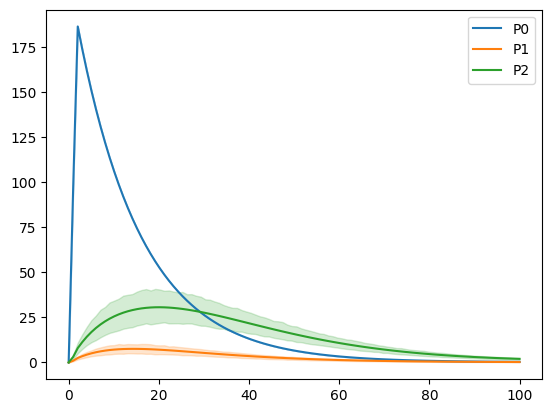

In [228]:
df = pd.DataFrame(data=ys.reshape((np.product(ys.shape[:-1]), ys.shape[-1])), index=ts.reshape(ts.size), columns=tf_names)

sns.lineplot(df, alpha=1, dashes=False)

<Axes: >

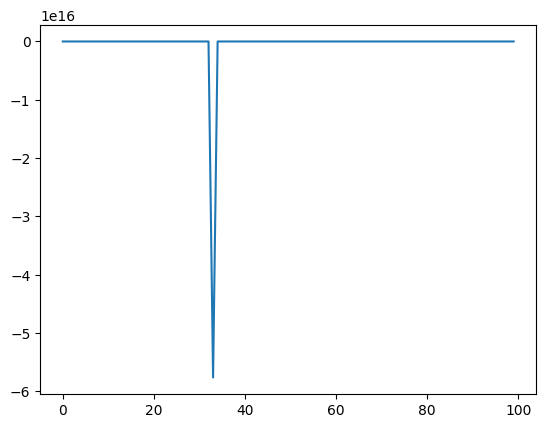

In [229]:
sns.lineplot(crs_all[0])